In [1]:
# %load_ext memory_profiler

# Capstone V5 again model

copy of V5.
The validation F1-score is {} at a threshold of {}.

# Constants

In [2]:
MODEL_VERSION = 'capstoneV5again'
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
MAX_WORDS = 50000

## Common english contraction mappings (wikipedia):
https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

In [3]:
CONTRACTION_MAPPING = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [4]:
PUNCT = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [5]:
SPECIAL_PUNCT = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}

In [6]:
PUNCT_MAPPING = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', }

In [7]:
MISPELL_MAPPING = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 'pokémon': 'pokemon'}

# Helpers

## Embedding helpers

In [8]:
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd
import os

def loadEmbeddings(path, dimensions, mode='r', encoding=None, errors=None):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    f = open(path, buffering=((2<<16) + 8), mode=mode, encoding=encoding, errors=errors)
    for line in f:
        if len(line) <= 100:
            continue
        values = line.split()
        word = ''.join(values[:-dimensions])
        coefs = np.asarray(values[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    f.close()
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [9]:
def loadEmbeddingsGensim(path, dimensions, binary=True):
    print('Loading embeddings from: %s' %path)
    embeddings = {}
    gensim_vecs = KeyedVectors.load_word2vec_format(path, binary=binary)
    for word, vector in zip(gensim_vecs.vocab, gensim_vecs.vectors):
        coefs = np.asarray(vector[-dimensions:], dtype='float32')
        embeddings[word] = coefs
    print('Found %s word vectors.' % len(embeddings))
    return embeddings

In [10]:
def getEmbeddingMatrix(embedding, word_index):
    all_embs = np.stack(embedding.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]
    
    nb_words = min(MAX_WORDS, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= MAX_WORDS:
            continue
        embedding_vector = embedding.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

### Helper to replace contractions in dataset

In [11]:
def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([CONTRACTION_MAPPING[t] if t in CONTRACTION_MAPPING else t for t in text.split(" ")])
    return text

### Helper to remap punctuations in dataset

In [12]:
def clean_special_chars(text):
    for p in PUNCT_MAPPING:
        text = text.replace(p, PUNCT_MAPPING[p])
    
    for p in PUNCT:
        text = text.replace(p, ' ' + p + ' ')
    
    for s in SPECIAL_PUNCT:
        text = text.replace(s, SPECIAL_PUNCT[s])
    
    return text

### Helper to correct common mispellings

In [13]:
def correct_spelling(x):
    for word in MISPELL_MAPPING.keys():
        x = x.replace(word, MISPELL_MAPPING[word])
    return x

## Coverage helpers

In [14]:
from collections import Counter

def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = Counter()
    for sentence in sentences:
        for word in sentence:
            vocab[word] += 1
    return vocab

In [15]:
import operator

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

# Import test/train dataset

In [16]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = -1

# Analyze train and test data

In [17]:
print("Sample insincere questions")
train_df.loc[train_df['target'] == 1].sample(10)

Sample insincere questions


,qid,question_text,target
339591,428710ca3c0b5de5fdb6,Do IITians eat cow dung?,1
403479,4f0ee7fbbadadc099912,Why do Chinese people and business company commit fraud?,1
1289442,fcb6d9dd1b7d1b75cdc2,Why aren’t Manafort’s assets frozen if he is a flight risk? Why isn’t he on suicide watch as well?,1
67580,0d3f7f24bf9b053fc99b,India and Pakistan leave Kashmir let Kashmiri decide there right by un resolution I don't understand what you digging about Kashmir all the time?,1
1286712,fc2b2199a2b4b6363b18,How come everyone seems to be transgender nowadays?,1
1129614,dd622868cd634bf3f47c,"With the recent Russian ""kompromat"" report on Donald Trump, do you think he may be stopped from taking office?",1
1172739,e5d05d5111942c447508,Why won't democrats support tax cuts so citizens can keep more of the money they earn?,1
106090,14c6326c075a87e5b70a,"I'm 10 years old and I love a 10 year old boy. When I try to talk to him, I get huge butterflies in my stomach and feel like I am floating. What does this mean?",1
246583,303c184200351a1fb448,When will Narendra Modi stop lying?,1
440252,5646d933f1304a180cf4,Why do all the Kannadigas from Chikmagalur and Hassan in Karnataka hate the people from Mangalore?,1


In [18]:
print("Sample sincere questions")
train_df.loc[train_df['target'] == 0].sample(10)

Sample sincere questions


,qid,question_text,target
911846,b2aef17d4691f02c4372,How did the genome project influence cladistics and taxonomy?,0
566508,6eff66573f0b3a4a2873,Why does Everyone have their own topic on Quora?,0
122564,17fd2660f2300646973d,What is the basis of morality?,0
844705,a5883673a1bb6109bceb,"Why I am not able to have control over my emotions when dealing with one I love, when in any other situation I am quite calm?",0
951860,ba851e6ffe1bf95277ce,Does light reflect on a surface and then go to your eye?,0
868418,aa26b4f1e65dd03c1b36,Is that mandatory for NRI to update aadhar card on LIC policy?,0
764539,95c907efe2fceed02692,"What are the top reasons you have to tell God exists, or doesn't exist?",0
749272,92c99098f73a2237efa9,Should you contact your ex after 3 years of breakup?,0
1071373,d1ee6f2efdb0d13b8b0a,"In making kimchi, most methods call for using dry salt, while some call for soaking the cabbage in saturated brine. Does it make any difference?",0
718489,8ca7e65a73fa9a897335,What is the point of calculating I raised to the power of I (seen on Quora) when we know I is not a number but an operator?,0


In [19]:
import matplotlib.pyplot as plt
import numpy as np

target_ratios = train_df.target.value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios (target)')
plt.show()

0    0.93813
1    0.06187
Name: target, dtype: float64


<Figure size 640x480 with 1 Axes>

In [20]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [21]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [22]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train_df['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test_df['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 70.


In [23]:
print('Max character length of questions in train is {0:.0f}.'.format(np.max(train_df['question_text'].apply(lambda x: len(x)))))
print('Max character length of questions in test is {0:.0f}.'.format(np.max(test_df['question_text'].apply(lambda x: len(x)))))

Max character length of questions in train is 1017.
Max character length of questions in test is 588.


In [24]:
print('p999 character length of questions in train is {0:.0f}.'.format(np.percentile(train_df['question_text'].apply(lambda x: len(x)), 99.9)))
print('p999 character length of questions in test is {0:.0f}.'.format(np.percentile(test_df['question_text'].apply(lambda x: len(x)), 99.9)))

p999 character length of questions in train is 249.
p999 character length of questions in test is 249.


# Data processing


## TODO: Feature engineering

Add feature engineering here.

In [25]:
%%time

train_df['treated_question'] = train_df['question_text'].apply(lambda x: x.lower())
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_contractions(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: clean_special_chars(x))
train_df['treated_question'] = train_df['treated_question'].apply(lambda x: correct_spelling(x))

test_df['treated_question'] = test_df['question_text'].apply(lambda x: x.lower())
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_contractions(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: clean_special_chars(x))
test_df['treated_question'] = test_df['treated_question'].apply(lambda x: correct_spelling(x))

CPU times: user 51.8 s, sys: 356 ms, total: 52.1 s
Wall time: 52.1 s


## Fill data

In [26]:
X_train = train_df['treated_question'].fillna('+++').tolist()
y_train = train_df['target']
X_test = test_df['treated_question'].fillna('+++').tolist()


print('Found %s training questions.' % len(X_train))
print('Found %s test questions.' % len(X_test))

Found 1306122 training questions.
Found 56370 test questions.


In [27]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=MAX_WORDS, lower=True, split=' ', filters='',
                       char_level=False, oov_token=None, document_count=0,
                      )
                                   
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Using TensorFlow backend.


Shape of X_train: (1306122, 100)
Shape of y_train: (1306122,)
Found 195975 unique tokens.


## Save tokenized data + word index

In [28]:
%%time

import gc
import pickle

test_df.to_pickle('test_df.pkl')

np.save('X_train.npy', X_train)
np.save('X_test.npy', X_test)
y_train.to_pickle('y_train.pkl')

pickle.dump(word_index, open('word_index.pkl', 'wb'))

del X_train
del X_test
del y_train

gc.collect()


CPU times: user 292 ms, sys: 632 ms, total: 924 ms
Wall time: 1.87 s


## Build vocabulary with counts

In [29]:
%%time

train_vocab = build_vocab(train_df['treated_question'])
del train_df
test_vocab = build_vocab(test_df['treated_question'])
del test_df

vocab = train_vocab + test_vocab
del train_vocab
del test_vocab

CPU times: user 14.3 s, sys: 648 ms, total: 14.9 s
Wall time: 14.9 s


## Load embeddings, measure coverage and save embedding matrix

# Restore point (optional)

In [30]:
'''
%%time

import pickle

word_index = pickle.load(open('word_index.pkl', 'rb'))
'''

"\n%%time\n\nimport pickle\n\nword_index = pickle.load(open('word_index.pkl', 'rb'))\n"

In [31]:
%%time

import gc

print('glove:')
glove_path = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
embeddings_index = loadEmbeddings(glove_path, EMBEDDING_DIM)
check_coverage(vocab, embeddings_index)
embedding_matrix = getEmbeddingMatrix(embeddings_index, word_index)
del embeddings_index
gc.collect()
np.save('glove.npy', embedding_matrix)

glove:
Loading embeddings from: ../input/embeddings/glove.840B.300d/glove.840B.300d.txt
Found 2195892 word vectors.
Found embeddings for 63.10% of vocab
Found embeddings for  99.39% of all text


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


CPU times: user 2min 54s, sys: 7.09 s, total: 3min 1s
Wall time: 2min 57s


In [32]:
del word_index
del vocab
gc.collect()

0

# Oversample training data

In [33]:
'''
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42, ratio = 1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)
'''


'\nfrom imblearn.over_sampling import SMOTE\n\nsm = SMOTE(random_state=42, ratio = 1.0)\nX_train, y_train = sm.fit_sample(X_train, y_train)\n'

In [34]:
'''
balanced_train_df = pd.DataFrame()
balanced_train_df[0] = np.array(y_train)

target_ratios = balanced_train_df[0].value_counts(normalize=True)

print(target_ratios)

target_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')
'''

"\nbalanced_train_df = pd.DataFrame()\nbalanced_train_df[0] = np.array(y_train)\n\ntarget_ratios = balanced_train_df[0].value_counts(normalize=True)\n\nprint(target_ratios)\n\ntarget_ratios.plot(kind='bar', title='Ratios after SMOTE (target)')\n"

# Setup model

# Restore point

In [35]:
%%time

import numpy as np
import pandas as pd
import pickle

test_df = pd.read_pickle('test_df.pkl')

X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = pd.read_pickle('y_train.pkl')


CPU times: user 32 ms, sys: 152 ms, total: 184 ms
Wall time: 186 ms


## Embeddings Layers

In [36]:
from keras.layers import Embedding

embedding_layers = {}

embedding_matrix = np.load('glove.npy')
embedding_layers['glove'] = Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=True)

## NN: Bidirectional GRU

In [37]:
%%time 

from keras.layers import Dense, Dropout, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, Bidirectional
from keras.layers import Activation, BatchNormalization, CuDNNGRU
from keras.layers import SpatialDropout1D, Concatenate, Flatten, Reshape
from keras.regularizers import l2
from keras.models import Model


inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

x = embedding_layers['glove'] (inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = GlobalMaxPool1D()(x)
x = Dense(32, kernel_regularizer=l2(0.01), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.1)(x)
x = Dense(16, kernel_regularizer=l2(0.01), use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dense(1, use_bias=False)(x)
x = BatchNormalization()(x)
out = Activation("sigmoid")(x)

model = Model(inp, out)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          140544    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4096      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
__________

In [38]:
from keras import backend as K


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
 
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+K.epsilon()))

# Compile the model

In [39]:


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1, recall, precision])

# serialize model

In [40]:
model.save('model.h5')
print("Saved model to disk")

Saved model to disk


# Setup f1-score, precision and recall metrics

In [41]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

checkpoints = ModelCheckpoint(MODEL_VERSION + '.weights_checkpoint.h5', monitor="val_f1", mode="max", verbose=True, save_best_only=True)

In [42]:
'''
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

class Metrics(Callback):


    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
 

    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average='binary')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))
        return

metrics = Metrics()
'''

'\nfrom keras.callbacks import Callback\nfrom sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support\n\nclass Metrics(Callback):\n\n\n    def on_train_begin(self, logs={}):\n        self.val_f1s = []\n        self.val_recalls = []\n        self.val_precisions = []\n \n\n    def on_epoch_end(self, epoch, logs={}):\n        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()\n        val_targ = self.validation_data[1]\n        _val_precision, _val_recall, _val_f1, _ = precision_recall_fscore_support(val_targ, val_predict, average=\'binary\')\n        self.val_f1s.append(_val_f1)\n        self.val_recalls.append(_val_recall)\n        self.val_precisions.append(_val_precision)\n        print(" — val_f1: %f — val_precision: %f — val_recall: %f" %(_val_f1, _val_precision, _val_recall))\n        return\n\nmetrics = Metrics()\n'

# Compute Class Weights

Since there is a significant target inbalance.

In [43]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

print (class_weights)

[0.53297527 8.08143794]


## Split train/validation

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,
                                              random_state=233)

/home/jupyter/.local/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# Train the model

Use model checkpointing to save the model that attains the best validation loss.

In [45]:
%%time

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
#          epochs=2, batch_size=128, callbacks=[metrics], class_weight=class_weights)

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val),
#          epochs=2, batch_size=128, class_weight=class_weights)

# hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], epochs=8, batch_size=512)

hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], class_weight=class_weights, epochs=2, batch_size=256)

#hist = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[checkpoints], class_weight=class_weights, initial_epoch=8, epochs=16, batch_size=512)



Train on 1044897 samples, validate on 261225 samples
Epoch 1/2
1044897/1044897 [==============================] - 111s 106us/step - loss: 0.2883 - acc: 0.9433 - f1: 0.6085 - recall: 0.6760 - precision: 0.5930 - val_loss: 0.1527 - val_acc: 0.9470 - val_f1: 0.2778 - val_recall: 0.1739 - val_precision: 0.8159

Epoch 00001: val_f1 improved from -inf to 0.27776, saving model to capstoneV5again.weights_checkpoint.h5
Epoch 2/2
1044897/1044897 [==============================] - 107s 103us/step - loss: 0.1121 - acc: 0.9614 - f1: 0.6548 - recall: 0.6117 - precision: 0.7288 - val_loss: 0.1139 - val_acc: 0.9564 - val_f1: 0.5244 - val_recall: 0.4071 - val_precision: 0.7847

Epoch 00002: val_f1 improved from 0.27776 to 0.52444, saving model to capstoneV5again.weights_checkpoint.h5
CPU times: user 4min 25s, sys: 42.9 s, total: 5min 8s
Wall time: 3min 40s


# Predict validation labels

In [46]:
%%time

pred_val = model.predict([X_val], batch_size=1024, verbose=1)

261225/261225 [==============================] - 3s 12us/step
CPU times: user 2.91 s, sys: 656 ms, total: 3.56 s
Wall time: 3.02 s


# Find optimal threshold

In [47]:
from sklearn.metrics import f1_score, precision_score, recall_score

def optimalThreshold(y_true,y_pred):
    idx = 0
    cur_f1 = 0
    cur_prec = 0
    cur_recall = 0
    max_f1 = 0
    thres = 0
    for idx in np.arange(0.1, 0.501, 0.01):
        cur_f1 = f1_score(y_true, np.array(y_pred)> idx)
        cur_recall = recall_score(y_true, np.array(y_pred)> idx)
        cur_prec = precision_score(y_true, np.array(y_pred)> idx)
        print('Current threshold is {:.4f} with F1 score: {:.4f}, Recall score: {:.4f}, Precision score: {:.4f}'
              .format(idx, cur_f1, cur_recall, cur_prec)
             )
        if cur_f1 > max_f1:
            max_f1 = cur_f1
            thres = idx
    print('optimal threshold is {:.4f} with F1 score: {:.4f}'.format(thres, max_f1))
    return thres
threshold = optimalThreshold(y_val,pred_val)

Current threshold is 0.1000 with F1 score: 0.6603, Recall score: 0.8001, Precision score: 0.5621
Current threshold is 0.1100 with F1 score: 0.6651, Recall score: 0.7895, Precision score: 0.5746
Current threshold is 0.1200 with F1 score: 0.6679, Recall score: 0.7766, Precision score: 0.5859
Current threshold is 0.1300 with F1 score: 0.6697, Recall score: 0.7649, Precision score: 0.5955
Current threshold is 0.1400 with F1 score: 0.6717, Recall score: 0.7541, Precision score: 0.6056
Current threshold is 0.1500 with F1 score: 0.6724, Recall score: 0.7424, Precision score: 0.6145
Current threshold is 0.1600 with F1 score: 0.6725, Recall score: 0.7311, Precision score: 0.6226
Current threshold is 0.1700 with F1 score: 0.6725, Recall score: 0.7204, Precision score: 0.6306
Current threshold is 0.1800 with F1 score: 0.6736, Recall score: 0.7110, Precision score: 0.6399
Current threshold is 0.1900 with F1 score: 0.6728, Recall score: 0.7013, Precision score: 0.6464
Current threshold is 0.2000 wi

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val, np.array(pred_val > threshold).astype(int), target_names=['sincere', 'insincere']))


              precision    recall  f1-score   support

     sincere       0.98      0.97      0.98    245044
   insincere       0.64      0.71      0.67     16181

   micro avg       0.96      0.96      0.96    261225
   macro avg       0.81      0.84      0.83    261225
weighted avg       0.96      0.96      0.96    261225



[Text(0, 0.5, 'sincere'), Text(0, 1.5, 'insincere')]

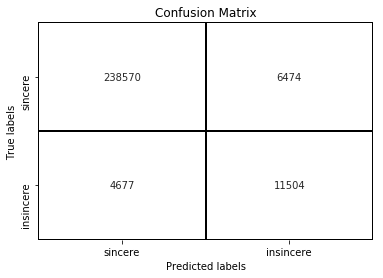

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cm = confusion_matrix(y_val, np.array(pred_val > threshold).astype(int))
ax = plt.subplot()
hm = sns.heatmap(cm, annot=True, ax = ax, fmt='g', 
                 cmap=ListedColormap(['white']), linecolor='black', 
                 linewidth=1, cbar=False,
                 xticklabels = 1, yticklabels = 1 )


# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['sincere', 'insincere'])
ax.yaxis.set_ticklabels(['sincere', 'insincere'])



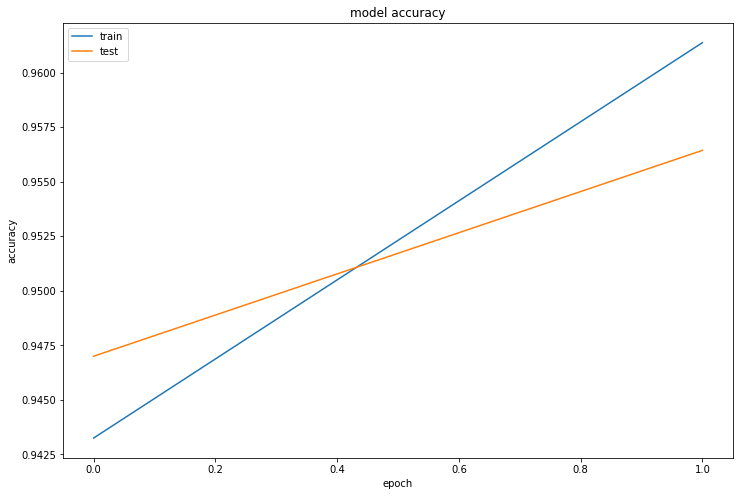

In [50]:
plt.figure(figsize=(12,8))
plt.title('model accuracy')
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

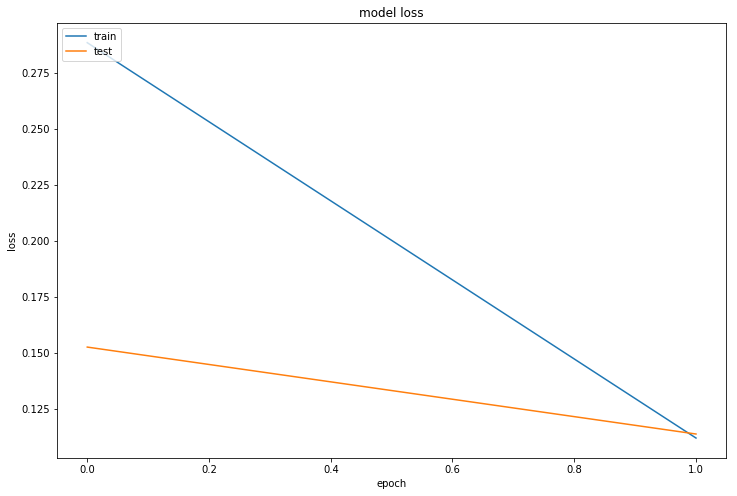

In [51]:
plt.figure(figsize=(12,8))
plt.title('model loss')
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

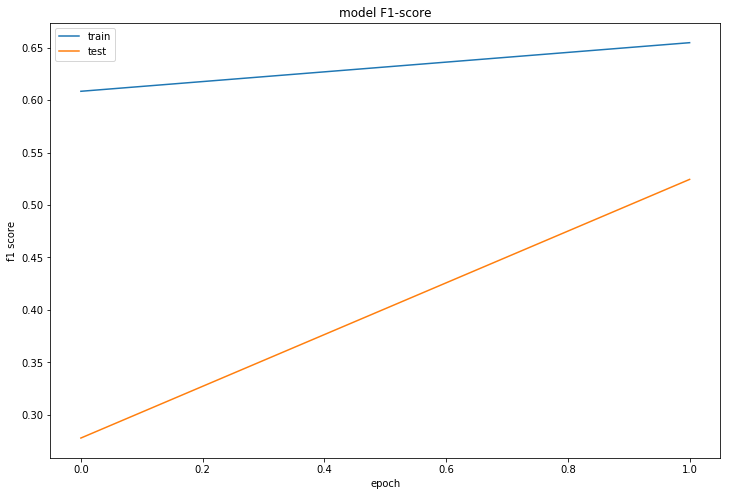

In [52]:
plt.figure(figsize=(12,8))
plt.title('model F1-score')
plt.plot(hist.history['f1'])
plt.plot(hist.history['val_f1'])
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize weights

In [53]:
model.save_weights(MODEL_VERSION + '.weights.h5')
print("Saved model weights to disk")

Saved model weights to disk


# Predict test labels

In [54]:
%%time

pred_test = model.predict([X_test], batch_size=1024, verbose=1)

56370/56370 [==============================] - 1s 11us/step
CPU times: user 592 ms, sys: 172 ms, total: 764 ms
Wall time: 640 ms


# Prepare submission

In [55]:
submission_df = pd.DataFrame({"qid":test_df["qid"].values})
submission_df['prediction'] = (pred_test > threshold).astype(int)
submission_df.to_csv("submission.csv", index=False)

In [56]:
type(hist)

keras.callbacks.History

In [57]:
import pickle


pickle_out = open(MODEL_VERSION + '.hist.pkl',"wb")
pickle.dump(hist, pickle_out)
pickle_out.close()